In [2]:
! pip install seaborn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd
import requests

def get_stock_data(stock_symbol, api_key= "DUZ9VGC19UMG5JW2"):
    """
    Retrieve stock data for a given stock symbol using the Alpha Vantage API.

    Args:
    - stock_symbol (str): The stock symbol (e.g., 'AAPL' for Apple Inc.).
    - api_key (str): Your Alpha Vantage API key.

    Returns:
    - df (DataFrame): A DataFrame containing the stock data.
    """

    # Construct the API URL
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": stock_symbol,
        "apikey": api_key,
        "outputsize": "full"  # Retrieve full historical data
    }

    # Make the API request
    try:
        response = requests.get(base_url, params=params)
        data = response.json()
    except requests.exceptions.RequestException as e:
        print("Error making API request:", e)
        return None

    # Check if the API request was successful
    if "Error Message" in data:
        print("Error:", data["Error Message"])
        return None

    # Parse the data into a DataFrame
    try:
        df = pd.DataFrame(data["Time Series (Daily)"]).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split(" ")[1] for col in df.columns]  # Clean column names
        df = df.astype(float)
    except Exception as e:
        print("Error parsing data:", e)
        return None

    return df


In [4]:
df_tesla = get_stock_data("TSLA")
df_tesla.head()

,open,high,low,close,volume
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0


In [5]:
df_tesla.shape

(3470, 5)

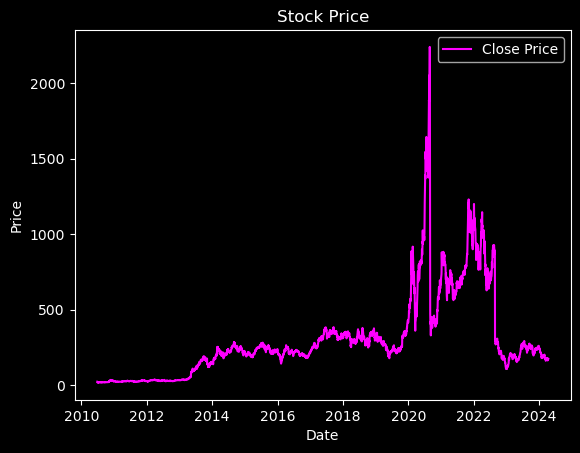

In [6]:

df = df_tesla.copy()
# Plot closing price
plt.style.use('dark_background')
plt.plot(df.index, df['close'], color='magenta', label='Close Price')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price')
plt.legend()

# Show plot

<Axes: >

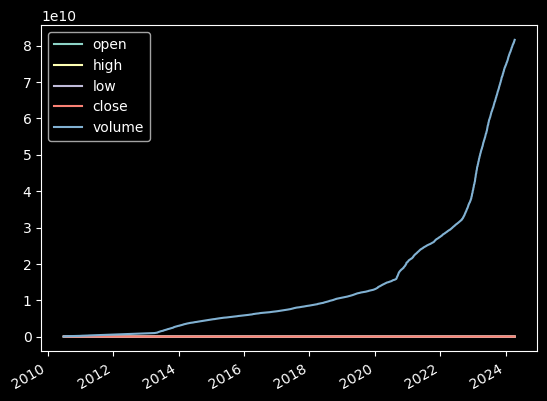

In [7]:

dr = df.cumsum()
dr.plot()

<Axes: >

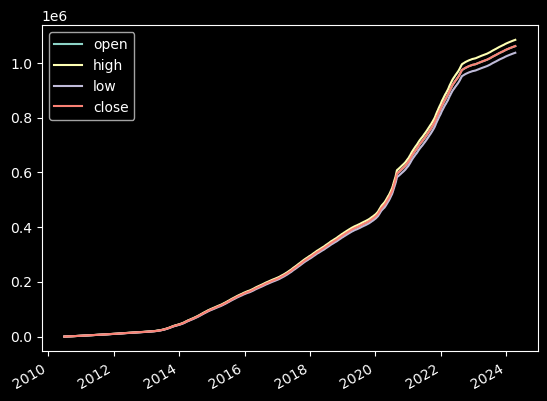

In [8]:
dr = dr.drop(columns=['volume'])
dr.plot()

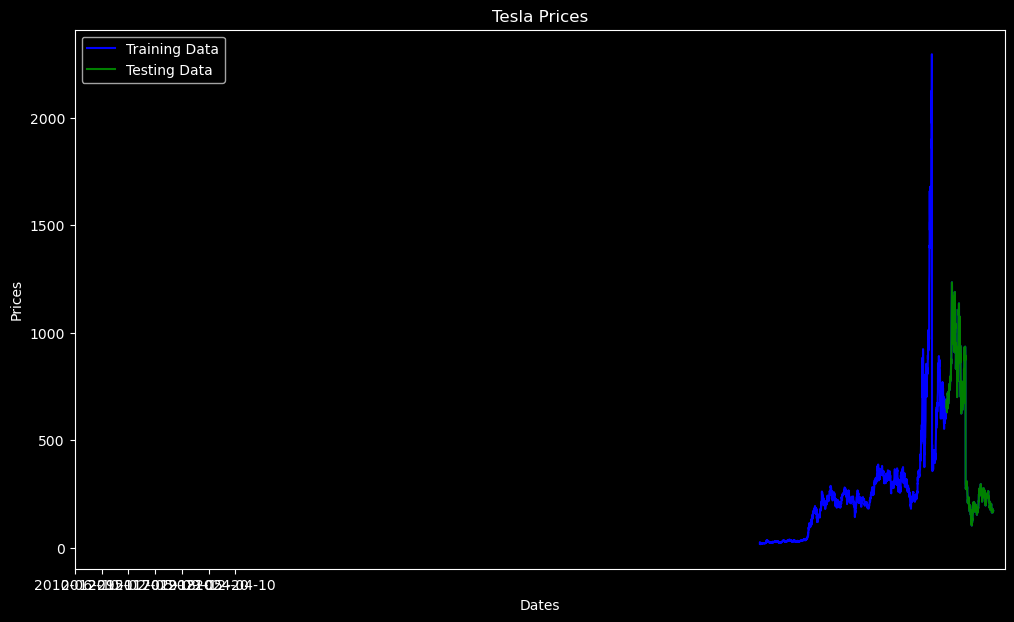

In [9]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

plt.figure(figsize=(12,7))
plt.title('Tesla Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.plot(df['open'], 'blue', label='Training Data')
plt.plot(test_data['open'], 'green', label='Testing Data')

# Set x-axis tick positions and labels
tick_positions = np.arange(0, len(df), len(df)//6)  # Divide the number of rows into 6 intervals
tick_labels = df.index[tick_positions].strftime('%Y-%m-%d')  # Assuming the index is a datetime index
plt.xticks(tick_positions, tick_labels)

plt.legend()
plt.show()


In [10]:
from statsmodels.tsa.arima.model import ARIMA

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

train_ar = train_data['open'].values
test_ar = test_data['open'].values
history = [x for x in train_ar]
predictions = []

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)

error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)


Testing Mean Squared Error: 1083.559
Symmetric mean absolute percentage error: 3.160


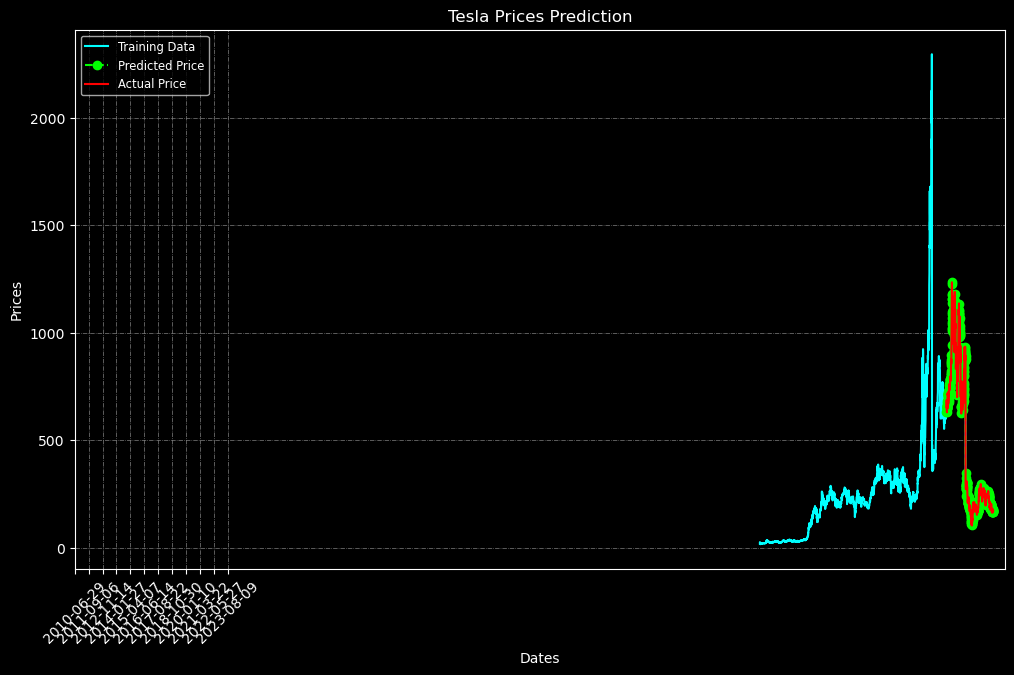

In [11]:
plt.figure(figsize=(12, 7))

# Define tick positions every 300 data points
tick_positions = np.arange(0, len(df), 300)

# Extract corresponding dates and format
tick_labels = df.index[tick_positions].strftime('%Y-%m-%d')

# Rotate xtick labels by 45 degrees for better readability
plt.xticks(tick_positions, tick_labels, color='white', rotation=45)

# Plot the data
plt.plot(df['open'], color='cyan', label='Training Data') 
plt.plot(test_data.index, predictions, color='lime', marker='o', linestyle='dashed', label='Predicted Price')  
plt.plot(test_data.index, test_data['open'], color='red', label='Actual Price') 

# Set title, xlabel, ylabel
plt.title('Tesla Prices Prediction', color='white') 
plt.xlabel('Dates', color='white')  
plt.ylabel('Prices', color='white')  

# Set xtick labels color to white and format dates
plt.xticks(tick_positions, tick_labels, color='white')

# Set ytick labels color to white
plt.yticks(color='white')  

# Set legend facecolor to black, location, and fontsize
plt.legend(facecolor='black', loc='upper left', fontsize='small')  

# Set background color to black
plt.gca().set_facecolor('black')  

# Add grid lines with gray color
plt.grid(color='gray', linestyle='-.', linewidth=0.5)  

plt.show()

